In [ ]:
"""
inference.py – оценка распределения финального PnL
для модели «ppo_deephedge_cnn2.zip»
"""

# ─── 1. конфиг ───────────────────────────────────────────────────────
MODEL_PATH   = "ppo_deephedge_cnn_l1.zip"    # ← имя из train.py
VECNORM_PATH = "vecnorm_cnn_l1.pkl"
LAMBDA_FIXED = 1                        # λ как на обучении
N_EPISODES   = 1000
DEVICE       = "cpu"                       # "cuda:0", если нужно

# ─── 2. импорты ──────────────────────────────────────────────────────
import numpy as np, pathlib, warnings
import torch as th
import matplotlib.pyplot as plt
from tqdm import tqdm

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from abm_env               import ABMDeepHedgeEnv
from risk_policy           import RiskAwarePolicy
from risk_rollout_buffer_v import RiskRolloutBufferV

# ─── 3. обёртка-фабрика среды  ───────────────────────────────────────
def make_env():
    return Monitor(ABMDeepHedgeEnv(lambda_fixed=LAMBDA_FIXED))

vec_env = DummyVecEnv([make_env])

# ─── 4. загружаем VecNormalize (если существует) ────────────────────
if pathlib.Path(VECNORM_PATH).is_file():
    vec_env = VecNormalize.load(VECNORM_PATH, vec_env)
    vec_env.training    = False        # freeze statistics
    vec_env.norm_reward = False
    print("VecNormalize stats loaded")
else:
    warnings.warn("VecNormalize stats NOT found – run without normalization")

# ─── 5. загружаем модель  ───────────────────────────────────────────
model = PPO.load(
    MODEL_PATH,
    env=vec_env,
    device=DEVICE,
    custom_objects={
        "policy": RiskAwarePolicy,
        "rollout_buffer_class": RiskRolloutBufferV,
    },
    print_system_info=False,
)
print("Model loaded:", MODEL_PATH)

# ─── 6. совместимость Gym ↔ Gymnasium ───────────────────────────────
def vreset(env):
    out = env.reset()
    return out if isinstance(out, tuple) else (out, {})

def vstep(env, action):
    out = env.step(action)
    if len(out) == 5:                       # gymnasium
        obs, rew, term, trunc, info = out
        return obs, rew, bool(term or trunc), info
    return out                              # gym ≤0.26

# ─── 7. запуск N_EPISODES  ──────────────────────────────────────────
final_pnls, rolling = [], []

for ep in tqdm(range(N_EPISODES)):
    obs, _ = vreset(vec_env)
    done, info_lst = False, [{}]

    while not done:
        with th.no_grad():
            action, _ = model.predict(obs, deterministic=True)
        obs, _, done, info_lst = vstep(vec_env, action)

    pnl = float(info_lst[0]["final_PnL"])
    final_pnls.append(pnl)

    rolling.append(pnl)
    if len(rolling) > 100:
        rolling.pop(0)

    print(f"Ep {ep:3d} | PnL {pnl:9.2f} | avg100 {np.mean(rolling):9.2f}", end="\r")

final_pnls = np.asarray(final_pnls, dtype=np.float32)

# ─── 8. визуализация распределения PnL ───────────────────────────────
plt.figure(figsize=(6, 3))
plt.hist(final_pnls, bins=30, alpha=0.8, edgecolor="k")
plt.axvline(np.mean(final_pnls), color="red",
            label=f"mean = {np.mean(final_pnls):.2f}")
plt.title("Final PnL distribution (CNN agent)")
plt.xlabel("PnL ($)")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


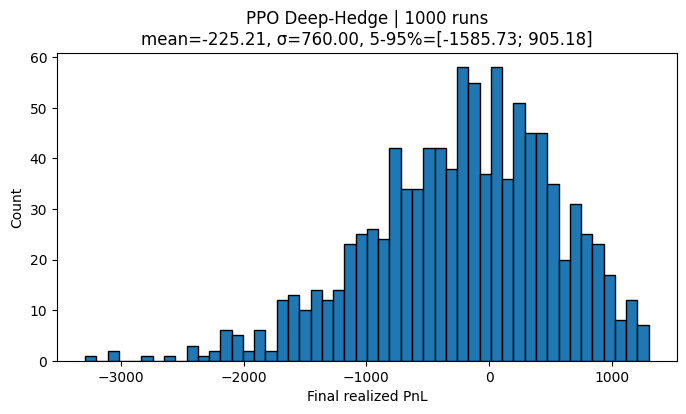


──────── summary ────────
Mean   PnL :  -225.2139
Std    PnL :   759.9988
5–95%  PnL : [-1585.73 ;   905.18]


In [2]:
# ─── 8. Гистограмма + summary ──────────────────────────────────────
mu, sigma = final_pnls.mean(), final_pnls.std(ddof=1)
p05, p95  = np.percentile(final_pnls, [5, 95])

plt.figure(figsize=(8, 4))
plt.hist(final_pnls, bins=50, edgecolor="black")
plt.xlabel("Final realized PnL")
plt.ylabel("Count")
plt.title(
    f"PPO Deep-Hedge | {N_EPISODES} runs\n"
    f"mean={mu:.2f}, σ={sigma:.2f}, 5-95%=[{p05:.2f}; {p95:.2f}]"
)
plt.show()

print("\n──────── summary ────────")
print(f"Mean   PnL : {mu:10.4f}")
print(f"Std    PnL : {sigma:10.4f}")
print(f"5–95%  PnL : [{p05:8.2f} ; {p95:8.2f}]")


In [3]:
import numpy as np

np.save('CNN, l1, 1000, 6', final_pnls)

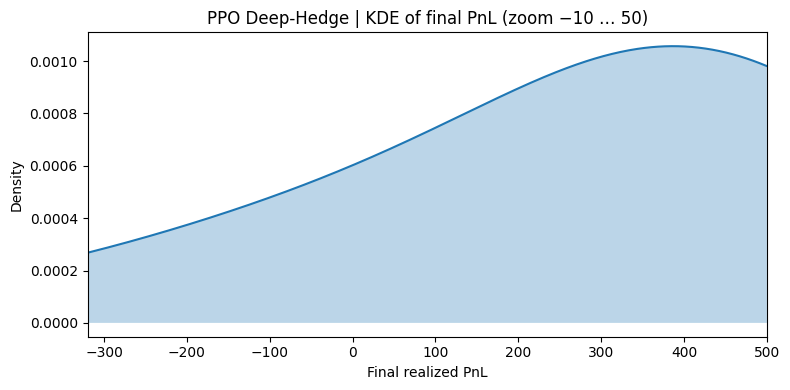

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure `final_pnls` is defined
try:
    data = np.asarray(final_pnls, dtype=float)
except NameError:
    raise RuntimeError("Variable `final_pnls` not found – please execute the cell where it is created.")

# Kernel Density Estimate (Gaussian)
from scipy.stats import gaussian_kde

kde = gaussian_kde(data)
x_grid = np.linspace(-320, 500, 400)
y_grid = kde(x_grid)

plt.figure(figsize=(8, 4))
plt.plot(x_grid, y_grid)
plt.fill_between(x_grid, y_grid, alpha=0.3)
plt.xlim(-320, 500)
plt.xlabel("Final realized PnL")
plt.ylabel("Density")
plt.title("PPO Deep‑Hedge | KDE of final PnL (zoom −10 … 50)")
plt.tight_layout()
plt.show()


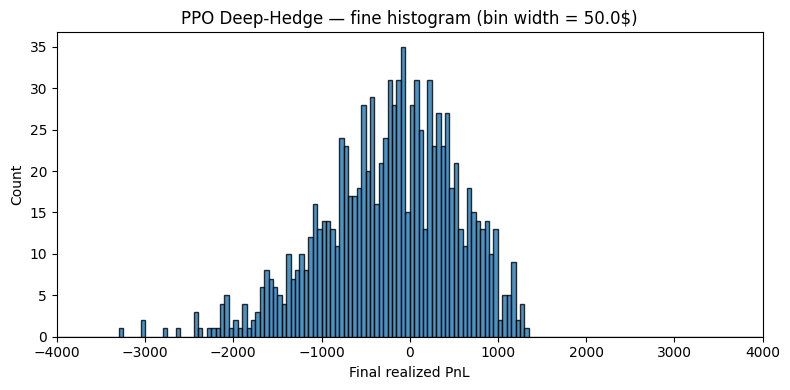

In [6]:
import numpy as np
import matplotlib.pyplot as plt

data = np.asarray(final_pnls, dtype=float)   # ← final_pnls уже есть
bin_width = 50.0
bins = np.arange(-4000, 4000 + bin_width, bin_width)

plt.figure(figsize=(8, 4))
plt.hist(data, bins=bins, edgecolor="black", alpha=0.8)
plt.xlim(-4000, 4000)
plt.xlabel("Final realized PnL")
plt.ylabel("Count")
plt.title(f"PPO Deep-Hedge — fine histogram (bin width = {bin_width}$)")
plt.tight_layout()
plt.show()


In [5]:
print(ma100)

NameError: name 'ma100' is not defined

In [7]:
ma100

[-1631.1523962504007,
 -1534.9209386941372,
 -1281.447828842242,
 -1203.608028533104,
 -1134.3037674901866,
 -1095.1199459474087,
 -984.1004963242465,
 -923.2397235920209,
 -868.6237815832202,
 -841.875443823514,
 -705.6745318540407,
 -690.3775029232236,
 -645.974379085187,
 -601.1181176802413,
 -549.6865715396275,
 -523.926915569241,
 -518.4347761610695,
 -503.1730728632317,
 -494.8050450883658,
 -481.8003704782169,
 -478.25049283083445,
 -468.03156623996614,
 -461.46922369101065,
 -418.2345062065108,
 -406.07853181558124,
 -397.4806224460337,
 -359.9679407060375,
 -332.4347370080716,
 -319.26309481281316,
 -300.42832109029945,
 -294.4869581701671,
 -275.0394046473355,
 -263.51771019387076,
 -257.3534601971555,
 -254.20763957170942,
 -251.76065680432626,
 -239.02731682629883,
 -236.61133620166405,
 -235.59482372069255,
 -224.25451767603573,
 -206.65250132967614,
 -155.4555812663033,
 -121.20200847846365,
 -113.60968355660869,
 -102.58823428269639,
 -50.952847675486524,
 18.11313207783

In [6]:
print(sorting)

None
